Load the presets which encapsulates de genre configuration

In [1]:
import pandas as pd

data = pd.read_csv('Data_info.csv')
data = data.drop(['No', 'Name','Genre', 'LR coeff', 'MS coeff'],axis=1)
presets = pd.read_csv('Presets.csv')
presets_columns  = presets.columns


presets

,Genre,RMS mean,RMS variance,RMS median,LUFS mean,LUFS variance,LUFS median,LRA mean,LRA variance,LRA median,...,DR median,Crest mean,Crest variance,Crest median,L-R mean,L-R variance,L-R median,M-S mean,M-S variance,M-S median
0,k-pop,0.314072,0.003795,0.328900,-7.132142,3.064172,-6.654704,2.036407,0.869366,1.786305,...,2.676841,4.491350,0.764286,4.224878,-0.001392,0.000110,-7.119775e-05,0.293190,0.005250,0.311200
1,country,0.241329,0.006723,0.275513,-10.037742,16.826958,-8.321598,2.790272,5.186674,1.988443,...,3.408020,6.039891,8.526821,4.727211,-0.003996,0.000366,-8.791685e-07,0.272584,0.009085,0.293815
2,electronic,0.280681,0.009542,0.283951,-9.430143,9.087101,-8.876348,2.807858,5.115818,2.151385,...,2.981449,5.109609,2.484223,4.727758,-0.004724,0.000555,-5.800948e-04,0.267206,0.009830,0.244891
3,rhythm and blues,0.125571,0.003001,0.127448,-15.309385,15.989467,-14.036294,3.576608,3.459156,2.943865,...,4.578034,8.238688,7.336685,7.332559,-0.002767,0.000144,-6.772578e-06,0.167640,0.036084,0.066732
4,pop,0.272467,0.005007,0.306534,-9.093468,5.809389,-8.219657,2.477309,2.317275,1.878145,...,3.117278,5.389067,2.720490,4.693603,0.001106,0.000081,3.679916e-04,0.264182,0.004346,0.283951
5,rock,0.226678,0.004388,0.235502,-9.672366,8.602966,-9.399834,3.958600,17.901244,2.423141,...,3.089710,5.657155,1.136697,5.524832,-0.006309,0.000225,-1.453534e-03,0.322498,0.003265,0.317723
6,soul,0.220601,0.006232,0.222140,-11.141374,10.530332,-10.839213,2.923278,5.575252,2.228832,...,3.403432,6.277279,2.998605,6.176161,0.001197,0.000440,-7.320270e-04,0.238798,0.013538,0.237711
7,disco,0.206483,0.007422,0.186951,-11.503699,10.350890,-11.849467,2.011746,1.437977,1.625134,...,2.364293,6.369441,3.634517,6.297736,-0.001113,0.000094,-1.050979e-03,0.269082,0.006022,0.274729
8,motown,0.145701,0.004562,0.170050,-14.351965,24.022685,-11.504507,2.035789,1.232818,2.275782,...,2.994955,6.036169,0.484260,6.036769,-0.003050,0.000062,-3.052637e-03,0.284591,0.016261,0.326661
9,funk,0.271853,0.008968,0.252165,-9.464091,8.867832,-9.311317,2.385779,2.765610,2.056415,...,2.829048,5.643104,2.176554,5.887260,-0.000641,0.000236,-9.984970e-04,0.182937,0.005721,0.171993


In [2]:
data

,RMS,LUFS,LRA,N peaks,DR,Crest
0,0.302042,-7.345446,2.343201,379,3.638462,4.837374
1,0.028993,-26.398939,9.634468,0,17.007402,9.915194
2,0.257117,-9.035285,4.512865,0,6.057836,5.015667
3,0.226135,-9.678103,2.521687,1817,4.240912,7.296312
4,0.321843,-7.630418,1.183287,87,1.800088,3.997015
...,...,...,...,...,...,...
483,0.387511,-4.678741,1.991619,3868,2.391020,3.420297
484,0.038257,-23.341423,8.616459,0,10.832956,13.930457
485,0.319802,-8.128967,1.776825,5,2.369351,4.144062
486,0.346236,-7.296785,1.153895,4888,1.808913,4.565301


In [3]:
import yaml
import os 
import essentia
from essentia.standard import *
import IPython
import matplotlib.pyplot as plt
import numpy as np

with open('../master-dynamics/metadata/genres.yaml') as g:
    genres = yaml.load(g, Loader=yaml.FullLoader)

all_genres = set(genres.values())
print(all_genres)


[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


{'rhythm and blues', 'hip-hop', 'reggae', 'electronic', 'motown', 'disco', 'funk', 'orchestral', 'metal', 'soul', 'jazz', 'pop', 'country', 'reggaeton', 'k-pop', 'rock', 'classical', 'house'}


# Presets configuration

This function is used for the process of normalization. Among the hole data we stablish the mean and standard deviation. These data is a csv file with 489 rows representing each song of the data set previosly analyzed. The columns represents the features of each song.

In [4]:
def mean_std(data):
    columns = data.columns
    #l contain the column name, min and max in idx 0,1,2
    l = []
    for column in columns:
        mean_col = data[column].mean()
        std_col = data[column].std()
        info = [column,mean_col,std_col]
        l.append(info)
        
    return l

mean_std(data)

[['RMS', 0.23176322791717763, 0.10191692788856661],
 ['LUFS', -10.984986846075683, 4.792711580211963],
 ['LRA', 3.1761751665932234, 2.8858106784285438],
 ['N peaks', 747.6700819672132, 4130.735998945464],
 ['DR', 4.615964149467213, 4.191606150108438],
 ['Crest', 6.191779163040098, 2.6563245810048053]]

The Z-score measures how many standard deviations a data point is away from the mean. A positive Z-score indicates that the data point is above the mean, and a negative Z-score indicates that the data point is below the mean.

To calculate the Z-score of a data point, you can use the following formula:

Z = (x - μ) / σ

where x is the data point, μ is the mean, and σ is the standard deviation.

Once you have calculated the Z-score, you can compare it to a threshold value to determine if the data point is an outlier. A common threshold value is ±3, meaning that any data point with a Z-score greater than 3 or less than -3 is considered an outlier.

However, it's important to note that outliers can be defined in different ways depending on the context and the distribution of the data. In some cases, it may be more appropriate to use a different threshold value or a different method for detecting outliers. It's also important to consider the underlying data generating process and to exercise judgment when interpreting outliers.

In [5]:
def normalize(values, feature, data):
    """
    The normalize function recieves an input value that could be any kind of feature.
    Given the data of the hole dataset and the mean and standard deviation for each feature
    (column in the csv file) we can obtain a normalization of the input value.
    S is an scaling factor stablished after the observation of the z-score in order to 
    obtain values between 0 and 1.
    2 outputs: the second one based on the scaling actor and z-score normalization,
    the first one is done especially for the visualization (until now, the second one is not
    relevant)
    
    Parameters
    ----------
    values : float array
        The first element is normalized
    feature : string
        Label. The normalization is different for each feature.
    data: Pandas dataframe
        Dataframe of the hole dataset, only including the feature levels.
    """
    
    feature_indices = {'RMS': 0, 'LUFS': 1, 'LRA': 2, 'N peaks': 3, 'DR': 4, 'Crest': 5}
    feature_index = None
    for key in feature_indices:
        if feature.startswith(key):
            feature_index = feature_indices[key]
            break
    if feature_index is None:
        raise ValueError(f"Feature '{feature}' not found in dictionary")
        
    mean, std = mean_std(data)[feature_index][1], mean_std(data)[feature_index][2]
    x_norm = (values[0] - mean) / std

    s = {
        'RMS': 1.47,
        'LUFS': 1.7,
        'LRA': 1.8,
        'N peaks': 0.85,
        'DR': 1.5,
        'Crest': 1.75
    }
    
    x_norm0 = 1/2 + x_norm/(2*s[key]); x_norm1 = x_norm0; 
    
    x_norm0 = 0 if np.isnan(x_norm0) or x_norm0 < 0 else x_norm0
    x_norm0 = 1 if x_norm0 > 1 else x_norm0
    
    #x_norm0 contain values strictly between 0 and 1.
    return x_norm0, x_norm1

Below we comptute all the presets configuration. We will use this in the radar chart plots.

In [6]:
radar_data = [['RMS', 'LUFS', 'LRA', 'peaks', 'DR', 'crest']]
rradar_data = [['RMS', 'LUFS', 'LRA', 'peaks', 'DR', 'crest']]

for genre in all_genres:
    g = presets.loc[presets['Genre'] == genre]
    rg = g.copy()
    
    for column in presets_columns:
        
        if column=='Genre':
            #initialize the list with the genre name
            gg = [g[column].values[0]]
            rgg = [rg[column].values[0]]
            gg_ = []
            rgg_ = []
            continue
        if column.startswith('L-R') or column.startswith('M-S'):
            continue
        if column.endswith('median') or column.endswith('variance'):
        #skip 2 iterations
            continue
            
        indx = g.columns.get_loc(column)
        #this array contains the mean, variance and median.
        values = [g.iloc[:,[indx]].values[0,0], g.iloc[:,[indx+1]].values[0,0],
                 g.iloc[:,[indx+2]].values[0,0]] 
        
        #we have to normalize a value to dorow = [] the plot
        #the normalize function must return a float between 0 and 1
        norm0, norm1 = normalize(values,column,data)
        gg_.append(norm0); rgg_.append(norm1)

    gg_ = [gg_]; rgg_ = [rgg_]
    gg.append(gg_); rgg.append(rgg_)
    radar_data.append(tuple(gg)); rradar_data.append(tuple(rgg))


In [7]:
radar_data

[['RMS', 'LUFS', 'LRA', 'peaks', 'DR', 'crest'],
 ('rhythm and blues',
  [[0.14559469439226547,
    0.23462165064273516,
    0.5385442381234671,
    0.3935284339930639,
    0.5444756199996581,
    0.7201655517489556]]),
 ('hip-hop',
  [[0.7122800230866787,
    0.6367059502089082,
    0.39894030792641133,
    0.4663742568251008,
    0.40893330655301924,
    0.35664120555075085]]),
 ('reggae',
  [[0.6106338627362999,
    0.597367808540845,
    0.38544873755822756,
    0.46033577508536905,
    0.3506907050411653,
    0.4008027187584441]]),
 ('electronic',
  [[0.6632572891932766,
    0.5954171686488765,
    0.4645471539673509,
    0.533124376961899,
    0.42704602652408846,
    0.38360172832653133]]),
 ('motown',
  [[0.21277671603095993,
    0.29337629200137383,
    0.39023056141062934,
    0.3935284339930639,
    0.3642573512694517,
    0.48326260497031404]]),
 ('disco',
  [[0.4156315400444682,
    0.4681678497095932,
    0.38791622858255864,
    0.42143511753430674,
    0.373463636926349

Després d'observar els resultats veiem que amb el z-score gairebé tots els valors mean per a cada feature oscila entre els -1 i 1, però sobretot en clàssica alguns valors es desvien bastant i aquests els voldrem representar en el radar chart. El que volem és normalitzar els valors entre 0 i 1 per lo que observem apuntem per a cada característica el maxim i el mínim. Aleshores el que s'ha de fer és escalar els resultats per un fator de $\frac{1}{2\times Z}$ i sumar $\frac{1}{2}$ perquè vagi de 0 a 1. En definitiva això és el que fa el normalize. Després en el plot, tots aquells valors que sigui menors que 0 i majors que 1 a la normalització es limitaran per a la representació gràfica, no obstant es tindran en compte pel processat de les demés funcions.

RMS: x1.47
LUFS: x1.7
LRA: x1.8
peaks: x0.82
DR: x1.5
Crest: 1.75

In [8]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

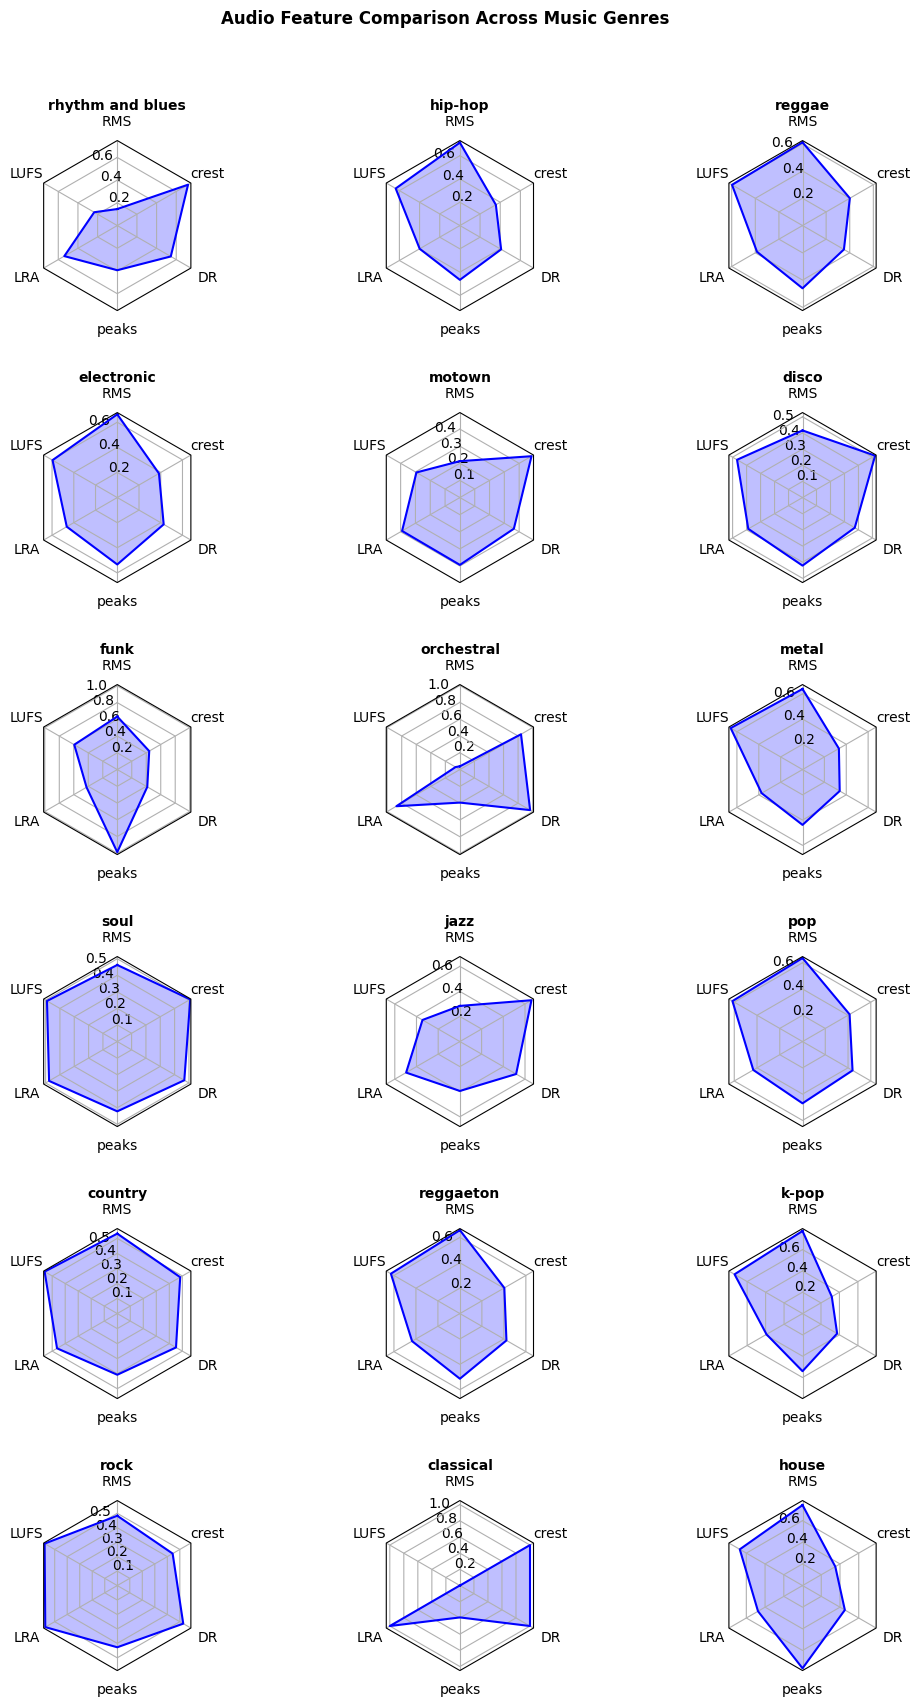

In [9]:
if __name__ == '__main__':
    N = 6
    theta = radar_factory(N, frame='polygon')

    spoke_labels = radar_data[0]
    radar_ = radar_data[1:]

    fig, axs = plt.subplots(figsize=(12, 18), nrows=6, ncols=3,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.4, hspace=0.6, top=0.9, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the cases on separate axes
    for ax, (title, case_data) in zip(axs.flat, radar_):
        #ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('RMS', 'LUFS', 'LRA', 'peaks', 'DR', 'crest')
    
    fig.text(0.5, 0.965, 'Audio Feature Comparison Across Music Genres',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

## The song
Sofware simulation...

In [10]:
import yaml
import os 
import essentia
from essentia.standard import *
import IPython
import matplotlib.pyplot as plt
import numpy as np

with open('../master-dynamics/metadata/genres.yaml') as g:
    genres = yaml.load(g, Loader=yaml.FullLoader)
    
with open('../master-dynamics/metadata/ids.yaml') as i:
    ids = yaml.load(i, Loader=yaml.FullLoader)

def rms_(audio):
    rms = RMS()
    return rms(audio)

def LUFS_LRA_(audio):
    
    ebur128 = LoudnessEBUR128()
    stereomuxer = StereoMuxer()
    if audio.ndim == 2:  
        audio = stereomuxer(audio[:,0], audio[:,1])
    else:
        audio = stereomuxer(audio, audio)
    
    ML, SL, IL, LRA = ebur128(stereo)
    return ML, SL, IL, LRA

def true_peak_(audio):
    peak_locations, output = TruePeakDetector(version=2)(audio)
    return peak_locations, output

def crest_(audio):
    crest = Crest()
    return crest(true_peak_(audio)[1])

def DR_(audio):
    ML, SL, IL, LRA = LUFS_LRA_(audio)
    return max(ML)-min(ML)

def mid_side(stereo):
    L = abs(stereo[:,0]); R=abs(stereo[:,1])
    M = L+R #mid
    S = L-R #side
    
    m = rms_(M) # mid energy
    s = rms_(S) #side energy
    l = rms_(L) #left energy
    r = rms_(R) #right energy

    # number between 0 and 1 that represent the side energy
    w_rate = s/m
    
    # number between -1 and 1 that represents the left-right energy rate
    h_rate = l-r
    
    return h_rate, w_rate

def plot_triangle(h_rate, w_rate):
    plt.figure(figsize=[5,5])
    theta = np.linspace(0, 2*np.pi, 100)
    x1 = np.cos(theta) 
    y1 = np.sin(theta) 

    plt.plot(x1, y1,color='grey', linestyle='dashed',
     linewidth=1, markersize=10)

    w = w_rate*90 
    h = h_rate*90
    beta = np.cos(np.pi*w/180)

    x = np.array([90+h+180,270-w+180,270+w+180,90+h+180])
    y = np.array([90+h+180,270-w+180,270+w+180,90+h+180])
    x = np.cos( x * np.pi / 180 )
    y = beta * np.sin( y * np.pi / 180 )

    ax1 = plt.plot()
    plt.plot( x, y, color='red' )
    plt.title('MID-SIDE')
    plt.show()



In [11]:
def norm_song(presets,feat,data):
    """
        Call the normalize function N times (6 times = 6 metrics) and makes an array of the
        normalized levels.
        
        Parameters
        -----------
        presets: Pandas dataframe
            Encapsulates the genres configuration
        feat: dicctionary
            Real levels of the song
        data: Pandas dataframe
            Dataframe of the hole dataset, only including the feature levels.
    """

    
    g = []
    rg = []
    for column in feat:
        values = [feat[column]]
        norm0, norm1 = normalize(values,column,data)
        g.append(norm0);
        rg.append(norm1)
    return g, rg

In [12]:
def song_features(audio,stereo,presets,data):
    """
    Call the extractors and return the normalized levels of the song
    
    Parameters
    -----------
    audio: 1D real float array
        Raw audio data in mono
    stereo: 2 real float 1D arrays
         Raw audio data in stereo (left and right channels)
    """
    RMS_v = rms_(audio)
    LUFS_v = LUFS_LRA_(stereo)[2]
    LRA_v = LUFS_LRA_(stereo)[3]
    PEAKS_v = len(true_peak_(audio)[0]) 
    CREST_v = crest_(audio)
    DR_v = DR_(audio)
    
    
    
    g = norm_song(presets, {'RMS':RMS_v,'LUFS':LUFS_v,'LRA':LRA_v,'N peaks':PEAKS_v,
                               'DR':DR_v,'Crest':CREST_v},data)
    
    
    return [g, [RMS_v, LUFS_v, LRA_v, PEAKS_v, DR_v, CREST_v]]

Fit is a function that return green or red depending if the levels of the song are good enough for the configuration of the preset genre selection. There are different ways of evaluate that.

1. Assuming that the data follows a normal distribution we can estimate either a sample is an outlier or not. This is done by (statistics name idk), We consider a sample is an outlier when it's more than 3 standar deviation away from the mean. Using this kind of approach we would obtain good results. Even though this software should be aware of the creativity of the users, i.e., there are features that are more relavant than others when we come to talk about (quality sound / high fidelity sound).

2. Therfore, we can create a new method based on measuring the distance between the current levels of the song and the ground truth. Each feature will have different weights and based on this and the distance between the normalized values of the radar chart we will estimate either a mix is correctly balanced.


In [13]:
def fit(song_data, presets, genre):
    #this function return green color if the mastering levels of the song fits with
    #the profile configuration
    
    feature_indices = {'RMS': 0, 'LUFS': 1, 'LRA': 2, 'N peaks': 3, 'DR': 4, 'Crest': 5}
 
    for key in feature_indices:
        g = presets.loc[presets['Genre'] == genre]
        std = np.sqrt(g[str(key+' variance')].values[0])
        mean = g[str(key+' mean')].values[0]
 
        
        if (3*std + mean < song_data[feature_indices[key]] or 
            mean - 3*std > song_data[feature_indices[key]]):
            return 'red'
        else:
            continue
    return 'green'

In [14]:
def fit2(song_norm_data, rradar_data, genre):
    feature_indices = {'RMS': 0, 'LUFS': 1, 'LRA': 2, 'N peaks': 3, 'DR': 4, 'Crest': 5}
    feature_weight = {'RMS': 0.05, 'LUFS': 0.4, 'LRA': 0.4, 'N peaks': 0.05, 
                      'DR': 0.05, 'Crest': 0.05}
    
    error = 0
    for gen in rradar_data:
        if gen[0]==genre:
            for key in feature_indices:
                g = gen[1][0][feature_indices[key]]
                distance = abs(song_norm_data[feature_indices[key]]-g)
                error += distance * feature_weight[key]
            break
    if error < 0.6: return ['green',error]
    else: return ['red',error]


In [15]:
def fit3(song_data, presets, genre):
    #this function return green color if the mastering levels of the song fits with
    #the profile configuration
    
    feature_indices = {'RMS': 0, 'LUFS': 1, 'LRA': 2, 'N peaks': 3, 'DR': 4, 'Crest': 5}
    error_values = {'RMS': 0.3, 'LUFS': 1, 'LRA': 1, 'N peaks':0.1,
                    'DR': 0.1, 'Crest': 0.1}
    error = 0
    
    for key in feature_indices:
        g = presets.loc[presets['Genre'] == genre]
        std = np.sqrt(g[str(key+' variance')].values[0])
        mean = g[str(key+' mean')].values[0]
        
        
        if (3*std + mean) < song_data[feature_indices[key]]:
            std_dist = abs((3*std+mean) - song_data[feature_indices[key]]) / std
            error += std_dist * error_values[key]
       
        if (mean - 3*std) > song_data[feature_indices[key]]:
            std_dist = abs((mean-3*std) - song_data[feature_indices[key]]) / std
            error += (1+std_dist) * error_values[key]

    if error > 2: return  'red'
    else: return 'green'

In [16]:
num_song = 240

In [17]:
path = '../master-dynamics/audio/'
file_name = '{}{}.mp3'.format(path,num_song)
#check if exists
audio = MonoLoader(filename=file_name)()
stereo, fs, n_channels, md5, bit_rate, codec = AudioLoader(filename=file_name)() #dos arrays esquerra i dreta

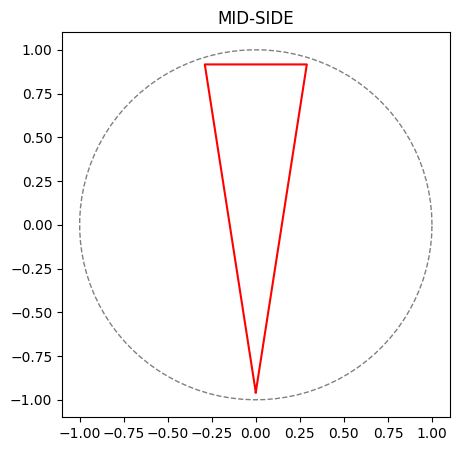

hip-hop
([0.6608143187294302, 0.6122829475168668, 0.2545917529481322, 0.3976581637878915, 0.4164697995558073, 0.32614715916761383], [0.6608143187294302, 0.6122829475168668, 0.2545917529481322, 0.3976581637878915, 0.4164697995558073, 0.32614715916761383])


In [18]:
h_rate, w_rate = mid_side(stereo)
plot_triangle(h_rate, w_rate)
genre_name = genres[num_song]
print(genre_name)
#es pot representar en dB
song_norm_data,song_data  = song_features(audio,stereo,presets,data)
print(song_norm_data)

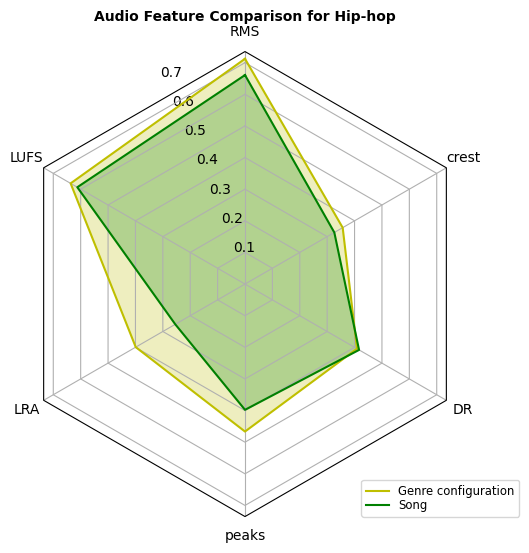

In [19]:
if __name__ == '__main__':
    
    N = 6
    theta = radar_factory(N, frame='polygon')
    
    genre_name = genres[num_song]
    
    for genre_info in radar_data:
        if genre_info[0] == genre_name:
        # found the matching genre, print its information
            break
        
    genre, data_conf = genre_info
    song, data_song = ('song', [song_norm_data[0]])

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.5, top=0.85, bottom=0.05)
    
    c = fit3(song_data, presets,genre)
    #c = fit2(song_norm_data[1],rradar_data, genre)[0]
     # add legend relative to top-left plot
    labels = ('RMS', 'LUFS', 'LRA', 'peaks', 'DR', 'crest')
    legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')
    
    # Plot the audio feature data on the axis
    #ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(f'Audio Feature Comparison for {genre.capitalize()}', weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    ax.plot(theta, data_conf[0], color='y')
    ax.fill(theta, data_conf[0], facecolor='y', alpha=0.25,label='_nolegend_')
    ax.plot(theta, data_song[0], color=c)
    ax.fill(theta, data_song[0], facecolor=c, alpha=0.25,label='_nolegend_')
    ax.set_varlabels(radar_data[0])

        # add legend relative to top-left plot
    labels = ('Genre configuration','Song')
    ax.legend(labels, loc=(.75, 0),labelspacing=0.1, fontsize='small')
    
    plt.show()

In [ ]:

#TESTING DIFFERENT FIT METHODS

non_fit_songs = []
for n_song in range(0,696):
    path = '../master-dynamics/audio/'
    file_name = '{}{}.mp3'.format(path,n_song)
    #check if exists
    genre_name = genres[n_song]
    try:
        
        audio = MonoLoader(filename=file_name)()
        stereo, fs, n_channels, md5, bit_rate, codec = AudioLoader(filename=file_name)() #dos arrays esquerra i dreta

        song_norm_data,song_data  = song_features(audio,stereo,presets,data)
        N = 6
        theta = radar_factory(N, frame='polygon')

        for genre_info in radar_data:
            if genre_info[0] == genre_name:
            # found the matching genre, print its information
                break

        genre, data_conf = genre_info
        song, data_song = ('song', [song_norm_data[0]])
        

        #fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
        #fig.subplots_adjust(wspace=0.5, top=0.85, bottom=0.05)

        c = fit3(song_data, presets,genre)
        if c == 'red':
            non_fit_songs.append(n_song)
        #c = fit2(song_norm_data[1],rradar_data, genre)[0]
         # add legend relative to top-left plot
#        labels = ('RMS', 'LUFS', 'LRA', 'peaks', 'DR', 'crest')
#        legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                                  labelspacing=0.1, fontsize='small')

        # Plot the audio feature data on the axis
        #ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
#        ax.set_title(f'Audio Feature Comparison for {genre.capitalize()}', weight='bold', size='medium', position=(0.5, 1.1),
#                     horizontalalignment='center', verticalalignment='center')
#        ax.plot(theta, data_conf[0], color='y')
#        ax.fill(theta, data_conf[0], facecolor='y', alpha=0.25,label='_nolegend_')
#        ax.plot(theta, data_song[0], color=c)
#        ax.fill(theta, data_song[0], facecolor=c, alpha=0.25,label='_nolegend_')
#        ax.set_varlabels(radar_data[0])

            # add legend relative to top-left plot
#        labels = ('Genre configuration','Song')
#        ax.legend(labels, loc=(.75, 0),labelspacing=0.1, fontsize='small')

#        plt.show()
        
    except:
        continue

In [ ]:
print(non_fit_songs)
len(non_fit_songs)